# PPO - Take 2

In [1]:
from collections import deque, namedtuple
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm
import pickle
import faulthandler

## Utility functions

In [2]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [3]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True, xlabel="Time Steps"):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        averages = moving_average(arr.mean(axis=0)) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        arr_err *= 1.96
        print(f"{(averages - arr_err).shape=}")
        ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                        color=color)
        # Save the plot handle
        h_list.append(h)

    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [5]:
def compute_grad_magnitudes(model):
    """Compute the total gradient magnitude for a model's gradients."""
    total_grad = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_grad += torch.norm(param.grad).item()
    return total_grad

In [6]:
def update_parent_info(parent_info, child_info, extend=False):
    for key, val in child_info.items():
        parent_info.setdefault(key, [])
        if extend and isinstance(val, list):
            parent_info[key].extend(val)
        else:
            parent_info[key].append(val)

In [7]:
def save_object(filename, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle)

## PPO Implementation

### Actor and Critic Networks

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_hidden=1, softmax=False):
        super().__init__()

        layers = [
            nn.Linear(input_dim, hidden_dim), # Input layer
            nn.ReLU()
        ]

        # Additional hidden layers
        if num_hidden > 1:
            for _ in range(num_hidden - 1):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim)) # Output layer

        if softmax:
            layers.append(nn.Softmax(dim=-1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.net(x)
        return x

In [9]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, num_hidden=1):
        super().__init__()

        self.actor = MLP(state_dim, action_dim, hidden_dim, num_hidden, softmax=True)
        self.critic = MLP(state_dim, 1, hidden_dim, num_hidden)

    def forward(self, x):
        state_value = self.critic(x)
        action_probs = self.actor(x)

        return state_value, action_probs

### PPO Agent

In [10]:
class PPOAgent(object):
    def __init__(self, state_dim, action_dim, hidden_dim=128, num_hidden=1):
        # Create the actor and critic networks
        self.actor_critic = ActorCritic(state_dim, action_dim, hidden_dim=hidden_dim, num_hidden=1)
        self.actor_critic.apply(init_weights)

    def get_action(self, state):
        # Sample an action from the actor network, return the action and its log probability,
        # and return the state value according to the critic network
        state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.actor_critic(state_tensor)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob, state_value

    def evaluate(self, states, actions):
        """
        Returns state value estimate and entropy of action distribution across a batch of states
        and log probability of taking given actions at those states
        """

        state_values, action_probs = self.actor_critic(states)
        m = Categorical(action_probs)

        return m.entropy(), m.log_prob(actions), state_values

    def save_model(self, path):
        torch.save(self.actor_critic.state_dict(), path)

    def load_model(self, path):
        self.actor_critic.load_state_dict(torch.load(path))

### Replay Buffer

In [11]:
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones', 'log_probs', 'state_values', 'returns')
)


class ReplayMemory:
    def __init__(self, max_size, state_dim):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_dim: Size of the state-space features for the environment
        """
        self.max_size = max_size
        self.state_dim = state_dim

        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        # self.boostrap_returns = torch.empty((max_size, 1))
        self.log_probs = []
        self.state_values = []

        # to store rewards-to-go, computed later
        self.returns = []

        # Preallocating all the required memory, for speed concerns
        # self.states = torch.empty((max_size, state_dim))
        # self.actions = torch.empty((max_size, 1), dtype=torch.long)
        # self.rewards = torch.empty((max_size, 1))
        # self.next_states = torch.empty((max_size, state_dim))
        # self.dones = torch.empty((max_size, 1), dtype=torch.bool)
        # # self.boostrap_returns = torch.empty((max_size, 1))
        # self.log_probs = torch.empty((max_size, 1))
        # self.state_values = torch.empty((max_size, 1))

        # # to store rewards-to-go, computed later
        # self.returns = torch.empty((max_size, 1))
        self.returns_computed = False

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done, log_prob, state_value):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        :param log_prob log of probability for selected action
        :param state_value s
        """

        if self.size == self.max_size:
            raise Exception('Buffer full!')

        # YOUR CODE HERE: Store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        self.states.append(torch.tensor(state))
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(torch.tensor(next_state))
        self.dones.append(done)

        # self.boostrap_returns[self.idx] = bootstrap_return
        self.log_probs.append(log_prob)
        self.state_values.append(state_value)

        # self.states[self.idx] = torch.tensor(state)
        # self.actions[self.idx] = action
        # self.rewards[self.idx] = reward
        # self.next_states[self.idx] = torch.tensor(next_state)
        # self.dones[self.idx] = done

        # # self.boostrap_returns[self.idx] = bootstrap_return
        # self.log_probs[self.idx] = log_prob
        # self.state_values[self.idx] = state_value

        # Increment the index
        self.idx += 1
        # Update the current buffer size
        self.size += 1 # = min(self.size + 1, self.max_size)

    def compute_returns(self, gamma, normalize=True):
        G = 0
        ep_returns = deque()
        returns_deq = deque()

        for i in range(self.size - 1, -1, -1):
            reward = self.rewards[i]
            done = self.dones[i]

            if done:
                # end of episode, reset discounted return calculation
                ep_returns.appendleft(G)
                G = 0

            # always detach returns, never take gradient w.r.t return
            G = gamma * G + reward #.detach().item()
            returns_deq.appendleft(G)

        self.returns = list(returns_deq)

        if normalize:
            returns = torch.tensor(self.returns)
            returns = (returns - returns.mean()) / (returns.std() + 1e-10)
            self.returns = returns.tolist()

        self.returns_computed = True

        return G, ep_returns

    def get_all(self):
        if not self.returns_computed:
            raise Exception('Returns not yet computed! Please call buffer.compute_returns() before sampling.')

        return Batch(
            torch.stack(self.states),
            torch.tensor(self.actions),
            torch.tensor(self.rewards),
            torch.stack(self.next_states),
            torch.tensor(self.dones),
            torch.tensor(self.log_probs),
            torch.tensor(self.state_values),
            torch.tensor(self.returns)
        )
        # return Batch(
        #     self.states[:self.size],
        #     self.actions[:self.size],
        #     self.rewards[:self.size],
        #     self.next_states[:self.size],
        #     self.dones[:self.size],
        #     self.log_probs[:self.size],
        #     self.state_values[:self.size],
        #     self.returns[:self.size]
        # )


    def batches(self, batch_size):
        """Iterate through random batches of sampled transitions.

        :param batch_size: Number of transitions to sample in each batch
        :rtype: Batch
        """

        if not self.returns_computed:
            raise Exception('Returns not yet computed! Please call buffer.compute_returns() before sampling.')

        shuf_indices = torch.randperm(self.size, dtype=torch.long)

        for start_idx in range(0, self.size, batch_size):
            end_idx = start_idx + batch_size

            if end_idx > self.size:
                end_idx = self.size

            sample_indices = shuf_indices[start_idx:end_idx]

            batch = Batch(
                self.states[sample_indices],
                self.actions[sample_indices],
                self.rewards[sample_indices],
                self.next_states[sample_indices],
                self.dones[sample_indices],
                self.log_probs[sample_indices],
                self.state_values[sample_indices],
                self.returns[sample_indices]
            )

            yield batch

    def clear(self):
        # Free existing tensors
        del self.states[:]
        del self.actions[:]
        del self.rewards[:]
        del self.next_states[:]
        del self.dones[:]
        del self.log_probs[:]
        del self.state_values[:]
        self.returns.clear()

        self.returns_computed = False

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

### Grokfast-EMA

In [15]:
from typing import Optional, Dict
# from grokfast paper - https://arxiv.org/abs/2405.20233
def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.98,
    lamb: float = 2.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads

### Gradient Adaptive Entropy (GrAdE)

In [24]:
from grade import GradientAdaptiveEntropy

### Training Loop

In [ ]:
class PPOAgentTrainer(object):
    def __init__(self, agent: PPOAgent, env: gym.Env, params):
        # Agent object
        self.agent = agent

        # Environment object
        self.env = env

        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.buffer = ReplayMemory(max_size=params['buffer_size'], state_dim=params['state_dim'])

        # Hyperparameters

        self.gamma = params['gamma'] # Gamma - discount factor
        self.epsilon = params['clip_epsilon'] # epsilon for PPO-Clip
        self.k_epochs = params['epochs_per_update'] # how many optimizer steps every PPO update
        self.entropy_coef = params['entropy_coef'] # entropy bonus coefficient
        self.use_grade = params.get('use_grade', False) # use Gradient Adaptive Entropy
        if self.use_grade:
            self.grade_tracker = GradientAdaptiveEntropy(self.agent.actor_critic.actor, entropy_coef=self.entropy_coef)

        self.use_grokfast = params.get('grokfast', False) # Use grokfast
        # keep track of grads for grokfast
        self.actor_grads = None
        self.critic_grads = None

        self.optimizer_actor = torch.optim.Adam(agent.actor_critic.actor.parameters(), lr=params['actor_learning_rate'])
        self.optimizer_critic = Adam(agent.actor_critic.critic.parameters(), lr=params['critic_learning_rate'])

    def ppo_one_epoch(self, states, actions, returns, state_values, old_log_probs, advantage):
        entropy_bonus, current_log_probs, latest_state_values = self.agent.evaluate(states, actions)

        # Probability ratio of selecting action at s, use log_prob for pi_theta_old
        # We take the actor gradient w.r.t current_log_probs
        ratio_t = torch.exp(current_log_probs - old_log_probs) # equivalent to e^current_log_probs / e^old_log_probs

        # Unclipped surrogate advantage
        unclipped_adv = ratio_t * advantage

        # Clipped surrogate advantage
        clipped_adv = torch.clamp(ratio_t, min=(1 - self.epsilon), max=(1 + self.epsilon))

        # Choose the minimum of the two (in the negative direction, if we choose a bad action, it should be bad)
        # unclipped chosen when ratio > 1+epsilon and advantage is negative
        # or when ratio < 1 - epsilon and advantage is positive
        # negative sign because torch Adam minimizes
        policy_loss = -torch.min(unclipped_adv, clipped_adv).mean()

        assert not torch.isnan(old_log_probs).any(), "Found NaN in log_probs"
        assert not torch.isnan(ratio_t).any(), "Found NaN in ratio_t"
        assert not torch.isnan(entropy_bonus).any(), "Found NaN in entropy_bonus"

        # Critic / value function estimate loss based on monte carlo return
        # value loss gradient is w.r.t. latest_state_values
        value_loss = F.mse_loss(latest_state_values, returns.unsqueeze(-1)).mean()

        # Incorporate entropy bonus
        policy_loss -= (self.entropy_coef * entropy_bonus.mean())


        # Gradient descent
        # ================
        # Optimize critic w.r.t value loss

        self.optimizer_critic.zero_grad()
        value_loss.backward()
        critic_grad_mag = compute_grad_magnitudes(self.agent.actor_critic.critic)
        if self.use_grokfast:
            self.critic_grads = gradfilter_ema(self.agent.actor_critic.critic, self.critic_grads)

        # if LOG_LEVEL == 'debug' or LOG_LEVEL == 'grads':

        #     print(f'Critic gradient magnitudes: {critic_grad_mag}')
        self.optimizer_critic.step()

        # Optimize actor w.r.t. policy loss
        self.optimizer_actor.zero_grad()
        policy_loss.backward()

        # print gradients
        actor_grad_mag = compute_grad_magnitudes(self.agent.actor_critic.actor)
        if self.use_grokfast:
            self.actor_grads = gradfilter_ema(self.agent.actor_critic.actor, self.actor_grads)
        # if LOG_LEVEL == 'debug' or LOG_LEVEL == 'grads':
        #     print(f'Actor gradient magnitudes: {actor_grad_mag}')
        self.optimizer_actor.step()

        epoch_stats = {
            'actor_grad_mag': actor_grad_mag,
            'critic_grad_mag': critic_grad_mag
        }

        return policy_loss, value_loss, epoch_stats

    def ppo_update(self):
        # def step_ppo_update(self, dataset: Batch):
        # Detach gradients for all collected data - don't compute gradients w.r.t them
        G, _ = self.buffer.compute_returns(self.gamma) # Compute returns for the collected episode
        data = self.buffer.get_all()

        states = data.states.detach()
        actions = data.actions.detach()
        returns = data.returns.detach()
        state_values = data.state_values.detach()
        old_log_probs = data.log_probs.detach()

        # Compute advantages based on MC returns
        advantage = (returns - state_values)

        # Normalize advantage
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-10) # add constant to prevent div by 0

        total_policy_loss = 0
        total_value_loss = 0

        info = {
            'episode_return': G
        }

        for epoch in range(self.k_epochs):
            epoch_policy_loss, epoch_value_loss, epoch_info = self.ppo_one_epoch(
                states, actions, returns, state_values, old_log_probs, advantage
                )

            total_policy_loss += epoch_policy_loss
            total_value_loss += epoch_value_loss
            update_parent_info(info, epoch_info, extend=True)

        # Detach gradients, these are only used for tracking statistics
        mean_policy_loss = total_policy_loss.detach() / self.k_epochs
        mean_value_loss = total_value_loss.detach() / self.k_epochs

        info['actor_loss'] = mean_policy_loss
        info['critic_loss'] = mean_value_loss
        info['combined_loss'] = mean_policy_loss + mean_value_loss

        self.buffer.clear() # collected data no longer valid

        return info

    def rollout(self):
        # Roll out one episode
        state, info = self.env.reset()
        done = False
        ep_len = 0
        sum_rewards = 0

        while not done:
            # Collect one transition
            action, log_prob, state_value = self.agent.get_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            # Bootstrap if truncated (???)
            # if truncated:
            #     _, _, next_state_value = self.agent.get_action(next_state)
            #     reward += self.gamma * next_state_value.detach()

            self.buffer.add(state, action, reward, next_state, done, log_prob, state_value)
            ep_len += 1
            sum_rewards += reward

            if not done:
                state = next_state

        return ep_len, sum_rewards


    def train(self):
        train_stats = {
            'episode_length': [],
            'episode_return': [],
            'undiscounted_return': [],
        }
        self.buffer.clear()

        filename = self.params.get('save_filename', None)

        # reset grads for grokfast
        self.actor_grads = None
        self.critic_grads = None
        if self.use_grade:
            self.grade_tracker.reset_stats()

        # ep_bar = tqdm.trange(self.params['num_episodes'], position=0, leave=True)
        for ep in range(self.params['num_episodes']):
            ep_len, undiscounted_return = self.rollout()
            train_stats['episode_length'].append(ep_len)
            train_stats['undiscounted_return'].append(undiscounted_return)

            # Train every episode
            if ep % self.params.get('train_frequency', 1) == 0:
                update_stats = self.ppo_update()
                update_parent_info(train_stats, update_stats, extend=True)

            # Compute moving average of rewards to track training progress
            avg_window = self.params['avg_return_window']

            if len(train_stats['undiscounted_return']) > avg_window:
                avg_undiscounted_return = np.mean(train_stats['undiscounted_return'][-avg_window:])
            else:
                avg_undiscounted_return = np.mean(train_stats['undiscounted_return'])

            if len(train_stats['episode_return']) > avg_window:
                avg_return = np.mean(train_stats['episode_return'][-avg_window:])
            else:
                avg_return = np.mean(train_stats['episode_return'])

            # Logging for tracking progress
            G = train_stats['episode_return'][-1]
            G_undiscounted = train_stats['undiscounted_return'][-1]
            loss = train_stats['combined_loss'][-1]

            if ep % self.params['log_frequency'] == 0 and ep > 0:
                print(f"Episode: {ep} | Return: {G:.3f} (Undiscounted: {G_undiscounted:.3f})| Moving Avg Return: {avg_return:3f} ({avg_undiscounted_return:.3f}) | Loss: {loss:.3f}")

            # ep_bar.set_description(f"Episode: {ep} | Return: {G} | Moving Avg Return: {avg_return} | Loss: {loss:.3f}")

            # Saving model checkpoints
            if filename is not None and ep % self.params['model_save_frequency'] == 0 and ep > 0:
                self.agent.save_model(f'{filename}-ep_{ep}.pth')

        # Training is complete
        # Save final model
        if filename is not None:
            self.agent.save_model(f'{filename}-ep_{ep}.pth')

        # Return training statistics
        return train_stats

## Train PPO on Lunar Lander

In [23]:
faulthandler.enable()

def train_ppo_lunar():
    env = gym.make('LunarLander-v3')

    num_episodes = 1500

    train_params = {
        # env info
        'state_dim': 8,

        # training params
        'num_episodes': num_episodes,
        'num_trials': 5,
        'buffer_size': 2_000,
        'train_frequency': 1, # train every episode
        # 'warmup_period': 10_000,

        # hyperparams
        'actor_learning_rate': 5e-4, #3e-4, # 3e-4,
        'critic_learning_rate': 1e-3, #1e-3, #1e-3,
        'gamma': 0.99,
        'entropy_coef': 0.01,
        'clip_epsilon': 0.2, # ppo clip constraint
        'epochs_per_update': 5,
        'save_filename': './checkpoints/lunar/ppo-lunar-lander',
        'model_save_frequency': num_episodes // 4,

        # Stats tracking parameters
        'avg_return_window': 25,
        'log_frequency': 50
    }

    trial_stats = {}

    for trial in range(train_params['num_trials']):
        print(f'Trial {trial}:')

        my_agent = PPOAgent(state_dim=train_params['state_dim'],
                            action_dim=4,
                            hidden_dim=128,
                            num_hidden=2)

        my_trainer = PPOAgentTrainer(my_agent, env, train_params)
        train_stats = my_trainer.train()
        update_parent_info(trial_stats, train_stats)

    return trial_stats


lunar_stats = train_ppo_lunar()
save_object('./ppo-ipy-lunar-stats.pkl', lunar_stats)

Trial 0:
Episode: 50 | Return: -17.240 (Undiscounted: -63.250)| Moving Avg Return: -74.282090 (-171.032) | Loss: 0.803
Episode: 100 | Return: -19.045 (Undiscounted: -47.514)| Moving Avg Return: -35.497875 (-94.450) | Loss: 0.216
Episode: 150 | Return: 2.919 (Undiscounted: 12.756)| Moving Avg Return: -15.839797 (-62.080) | Loss: 0.309
Episode: 200 | Return: -7.966 (Undiscounted: -45.305)| Moving Avg Return: -2.443101 (-47.376) | Loss: 0.366
Episode: 250 | Return: 19.252 (Undiscounted: 5.696)| Moving Avg Return: 8.959657 (-57.552) | Loss: 0.151
Episode: 300 | Return: 16.578 (Undiscounted: -0.133)| Moving Avg Return: 18.385753 (-72.205) | Loss: 0.568
Episode: 350 | Return: 52.176 (Undiscounted: -198.178)| Moving Avg Return: 26.029331 (-32.449) | Loss: 0.422
Episode: 400 | Return: 13.066 (Undiscounted: -3.427)| Moving Avg Return: 19.086960 (-31.922) | Loss: 0.871
Episode: 450 | Return: 5.504 (Undiscounted: -209.165)| Moving Avg Return: 30.254517 (26.578) | Loss: 0.188
Episode: 500 | Return

In [18]:
print(lunar_stats.keys())

dict_keys(['episode_length', 'episode_return', 'undiscounted_return', 'actor_loss', 'critic_loss', 'combined_loss'])


(averages - arr_err).shape=(1500,)


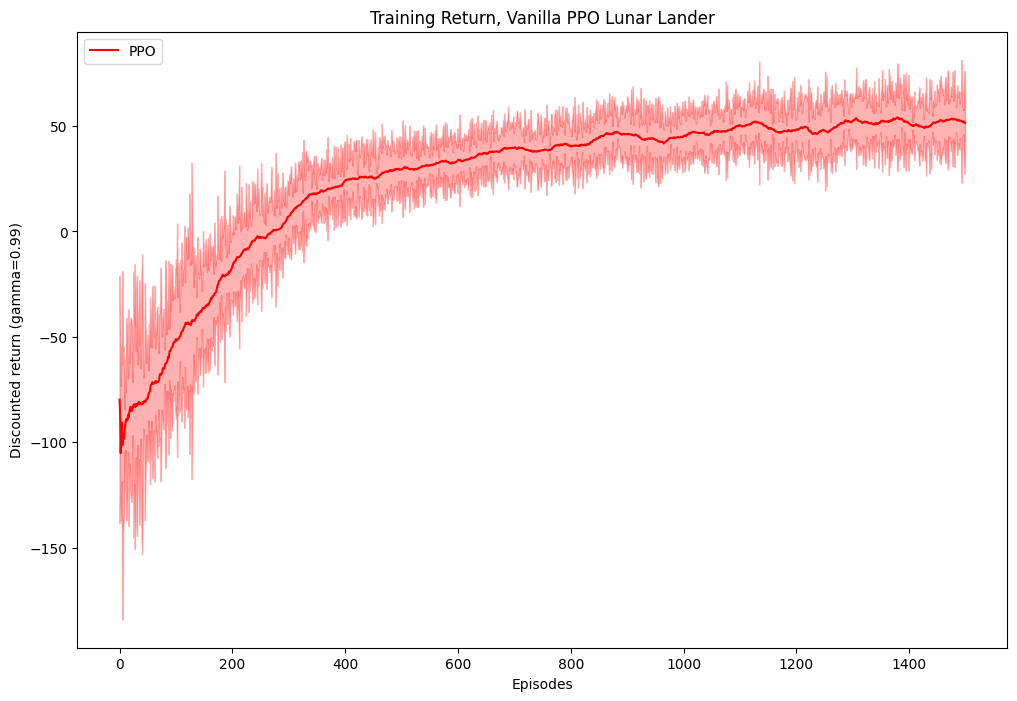

(averages - arr_err).shape=(1500,)


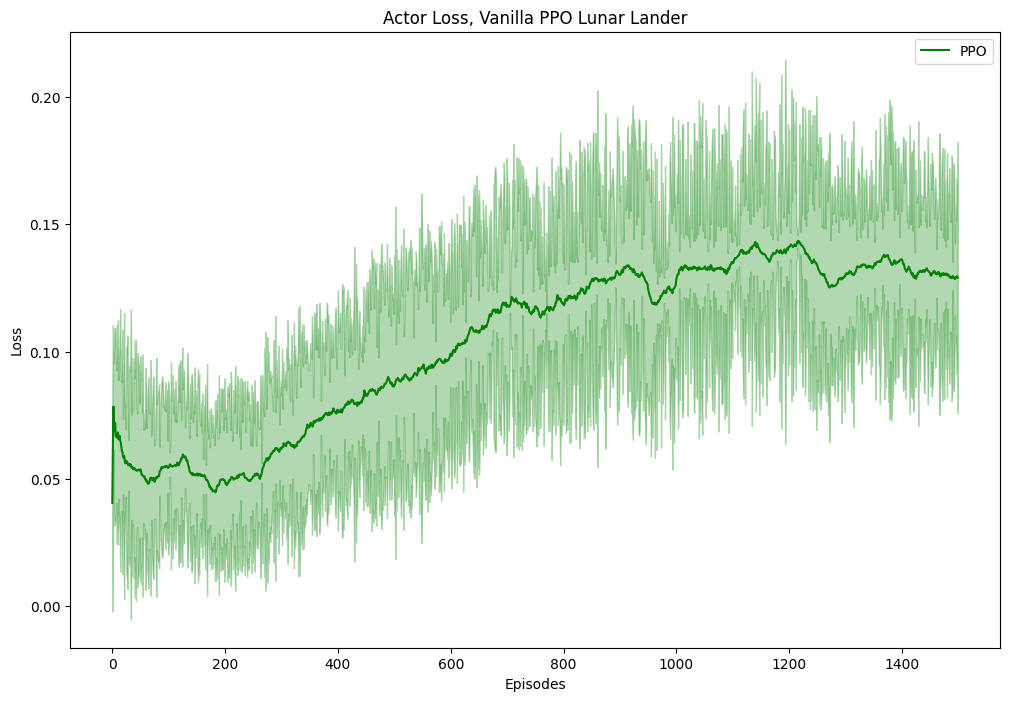

(averages - arr_err).shape=(1500,)


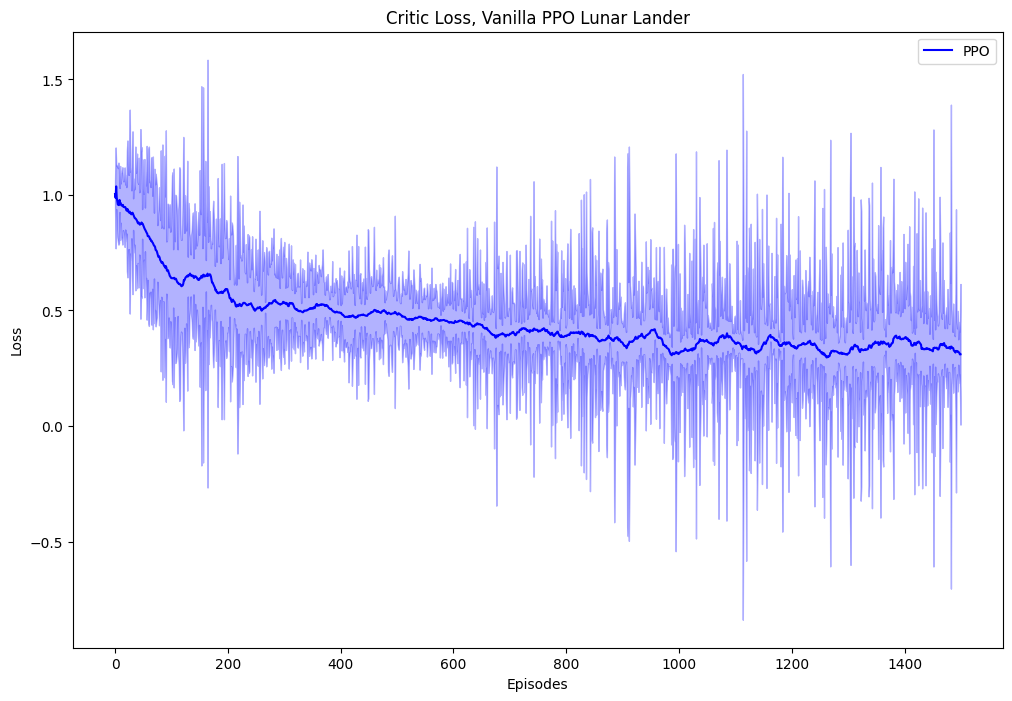

In [19]:
plot_curves([np.stack(lunar_stats['episode_return'])],
            ['PPO'],
            ['r'],
            xlabel='Episodes',
            ylabel='Discounted return (gamma=0.99)',
            fig_title='Training Return, Vanilla PPO Lunar Lander',
            smoothing=True)

plot_curves([np.stack(lunar_stats['actor_loss'])],
            ['PPO'],
            ['g'],
            xlabel='Episodes',
            ylabel='Loss',
            fig_title='Actor Loss, Vanilla PPO Lunar Lander',
            smoothing=True)

plot_curves([np.stack(lunar_stats['critic_loss'])],
            ['PPO'],
            ['b'],
            xlabel='Episodes',
            ylabel='Loss',
            fig_title='Critic Loss, Vanilla PPO Lunar Lander',
            smoothing=True)

In [ ]:
plot_curves([np.stack(lunar_stats['combined_loss'])],
            ['PPO'],
            ['teal'],
            xlabel='Episodes',
            ylabel='Loss',
            fig_title='Critic Loss, Vanilla PPO Lunar Lander',
            smoothing=True)

(averages - arr_err).shape=(1500,)


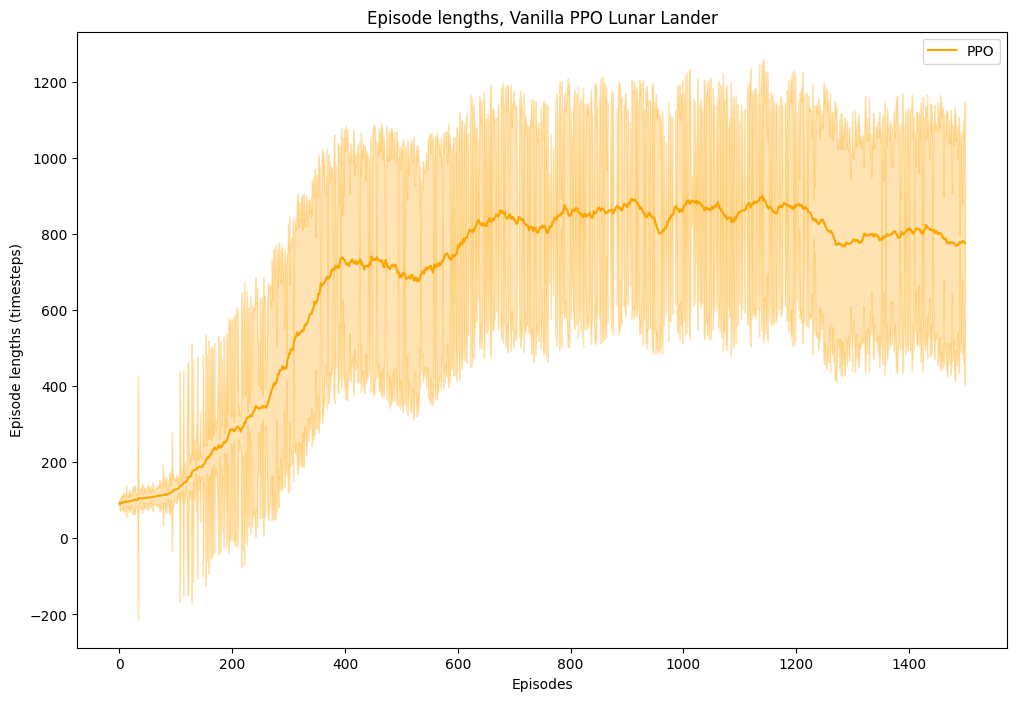

In [20]:
plot_curves([np.stack(lunar_stats['episode_length'])],
            ['PPO'],
            ['orange'],
            xlabel='Episodes',
            ylabel='Episode lengths (timesteps)',
            fig_title='Episode lengths, Vanilla PPO Lunar Lander',
            smoothing=True)

(averages - arr_err).shape=(1500,)


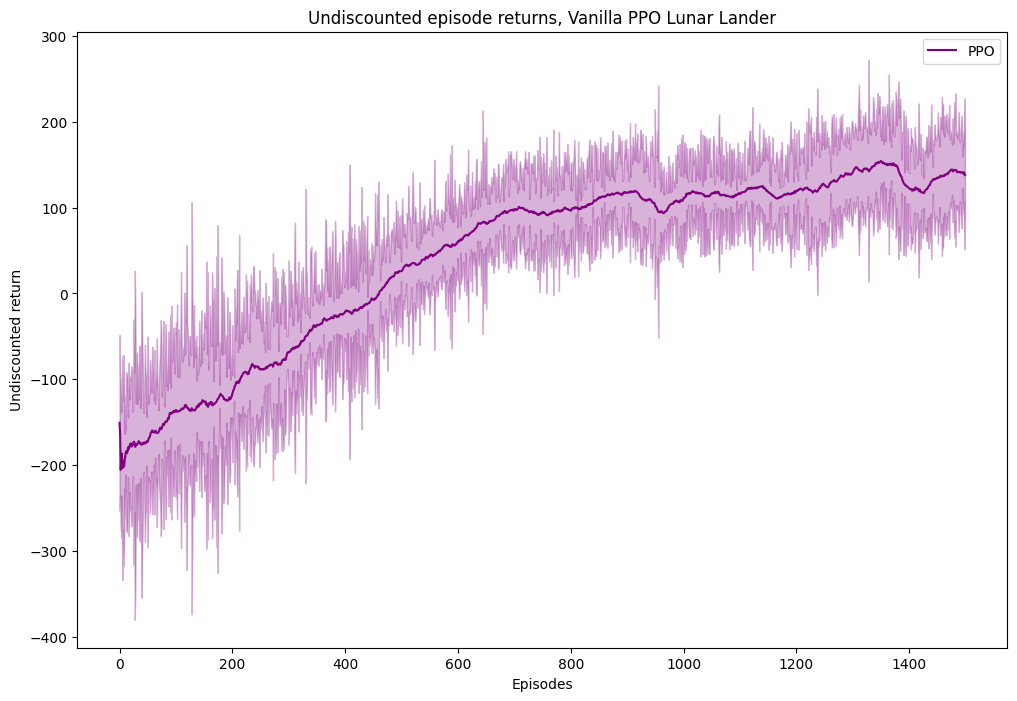

In [21]:
plot_curves([np.stack(lunar_stats['undiscounted_return'])],
            ['PPO'],
            ['purple'],
            xlabel='Episodes',
            ylabel='Undiscounted return',
            fig_title='Undiscounted episode returns, Vanilla PPO Lunar Lander',
            smoothing=True)

## Train PPO on Four Rooms

### Four Rooms Environment

In [31]:
class FourRooms(object):
    def __init__(self, reward_fn='sparse'):
        # The grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Observation (state) space consists of all empty cells
        # To improve interpretability, we flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # Action space
        self.action_movement = {0: np.array([0, 1]),  # up
                                1: np.array([0, -1]),  # down
                                2: np.array([-1, 0]),  # left
                                3: np.array([1, 0])}  # right
        self.action_space = spaces.Discrete(4)

        # Start location
        self.start_location = [0, 0]

        # Goal location
        self.goal_location = [10, 10]

        # Wall locations
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, with a timeout of 459 steps
        self.max_time_steps = 459

        # Tracking variables during a single episode
        self.agent_location = None  # Track the agent's location in one episode.
        self.action = None  # Track the agent's action
        self.t = 0  # Track the current time step in one episode

        # reward function type
        self.reward_fn = reward_fn

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates ((row, col), origin is top left)
        to the Four Rooms coordinates ((x, y), origin is bottom left)
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): List variable consisting of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): List variable consisting of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # Reset the agent's location to the start location
        self.agent_location = self.start_location

        # Reset the timeout tracker to be 0
        self.t = 0

        # Reset the information
        info = {}
        return self.compute_state_feature(self.agent_location), info

    def step(self, action):
        """
        Args:
            action (int): Int variable (i.e., 0 for "up"). See self.action_movement above for more details.
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == 2 or action == 3:
                action = np.random.choice([0, 1], 1)[0]
            else:
                action = np.random.choice([2, 3], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_movement[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls; if so, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward (1 iff next state is goal location)
        if self.reward_fn == 'dense':
            reward = 0.0 if next_agent_location == self.goal_location else -1.0
        elif self.reward_fn == 'manhattan':
            manhattan_dist = np.abs(np.array(next_agent_location) - np.array(self.goal_location)).sum()
            reward = -manhattan_dist
        else:
            reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check termination/truncation
        # If agent reaches the goal, reward = 1, terminated = True
        # If timeout is reached, reward = 0, truncated = True
        terminated = False
        truncated = False
        if reward == 1.0:
            terminated = True
        elif self.t == self.max_time_steps:
            truncated = True

        # Update the agent's location, action, and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return self.compute_state_feature(next_agent_location), reward, terminated, truncated, {}

    def render(self):
        # Plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action_movement[self.action]}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def compute_state_feature(state):
            return [state[0] / 10, state[1] / 10, 1]

    @staticmethod
    def test():
        env = FourRooms()
        state, info = env.reset()

        for _ in range(1000):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            env.render()
            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

# Un-comment to run test function
# FourRooms.test()

### Experiment

In [ ]:
def train_ppo_four_rooms():
    env = FourRooms(reward_fn='dense')

    num_episodes = 1000

    train_params = {
        # env info
        'state_dim': 3,

        # training params
        'num_episodes': num_episodes,
        'num_trials': 1,
        'buffer_size': 2_000,
        'train_frequency': 4, # every 4 episodes
        # 'warmup_period': 10_000,

        # hyperparams
        'actor_learning_rate': 5e-4, #3e-4, # 3e-4,
        'critic_learning_rate': 5e-4, #1e-3,
        'gamma': 0.99,
        'entropy_coef': 0.01,
        'clip_epsilon': 0.2, # ppo clip constraint
        'epochs_per_update': 5,
        'save_filename': './ppo-four-rooms',
        'model_save_frequency': num_episodes // 4,

        # Stats tracking parameters
        'avg_return_window': 25,
        'log_frequency': 50
    }

    trial_stats = {}

    for trial in range(train_params['num_trials']):
        print(f'Trial {trial}:')

        my_agent = PPOAgent(state_dim=train_params['state_dim'],
                            action_dim=4,
                            hidden_dim=128,
                            num_hidden=2)

        my_trainer = PPOAgentTrainer(my_agent, env, train_params)
        train_stats = my_trainer.train()
        update_parent_info(trial_stats, train_stats)

    return trial_stats


four_rooms_stats = train_ppo_four_rooms()
save_object('./ppo-four-rooms-stats.pkl', four_rooms_stats)

Trial 0:
Episode: 50 | Return: -98.29153360840564 (Undiscounted: -450.0)| Moving Avg Return: -447.8 | Loss: 0.932
Episode: 100 | Return: -99.01782355409692 (Undiscounted: -460.0)| Moving Avg Return: -371.72 | Loss: 1.000
Episode: 150 | Return: -95.99860030996109 (Undiscounted: -341.0)| Moving Avg Return: -356.72 | Loss: 0.399
Episode: 200 | Return: -99.01782355409692 (Undiscounted: -460.0)| Moving Avg Return: -274.76 | Loss: 1.262
Episode: 250 | Return: -80.14343011007831 (Undiscounted: -306.0)| Moving Avg Return: -330.2 | Loss: 0.976
Episode: 300 | Return: -99.01782355409692 (Undiscounted: -460.0)| Moving Avg Return: -349.76 | Loss: 1.048
Episode: 350 | Return: -73.09532809650564 (Undiscounted: -256.0)| Moving Avg Return: -329.04 | Loss: 0.958
Episode: 400 | Return: -92.98315872630403 (Undiscounted: -302.0)| Moving Avg Return: -336.16 | Loss: 0.521
Episode: 450 | Return: -99.01782355409692 (Undiscounted: -460.0)| Moving Avg Return: -359.44 | Loss: 1.355
Episode: 500 | Return: -99.0178

In [14]:
print(four_rooms_stats.keys())

NameError: name 'four_rooms_stats' is not defined

(averages - arr_err).shape=(1000,)


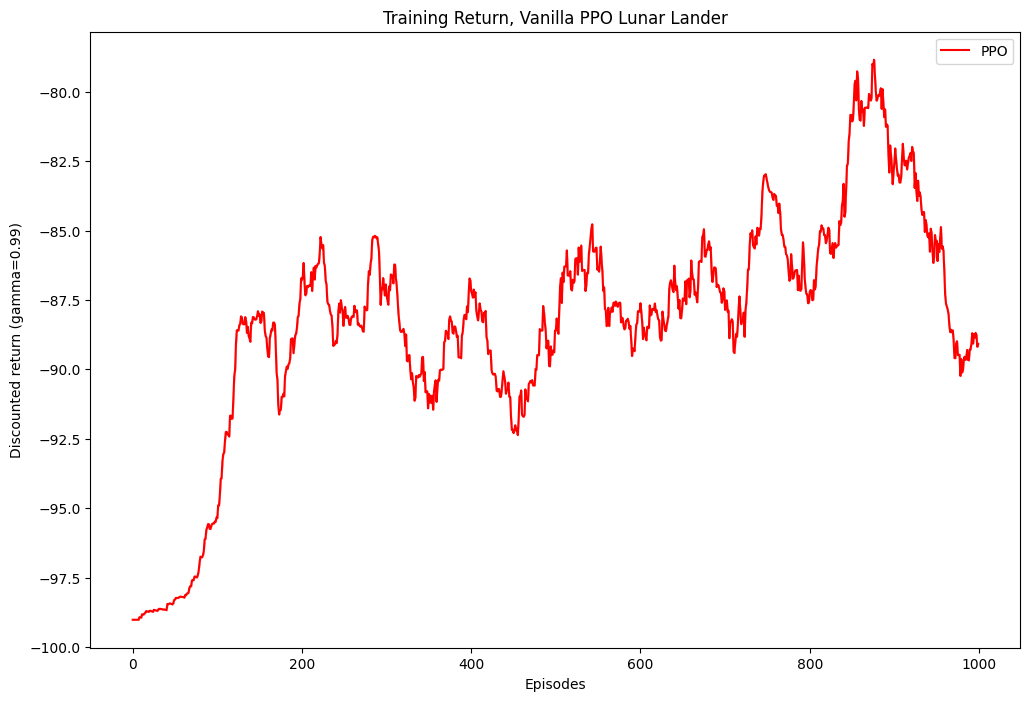

(averages - arr_err).shape=(1000,)


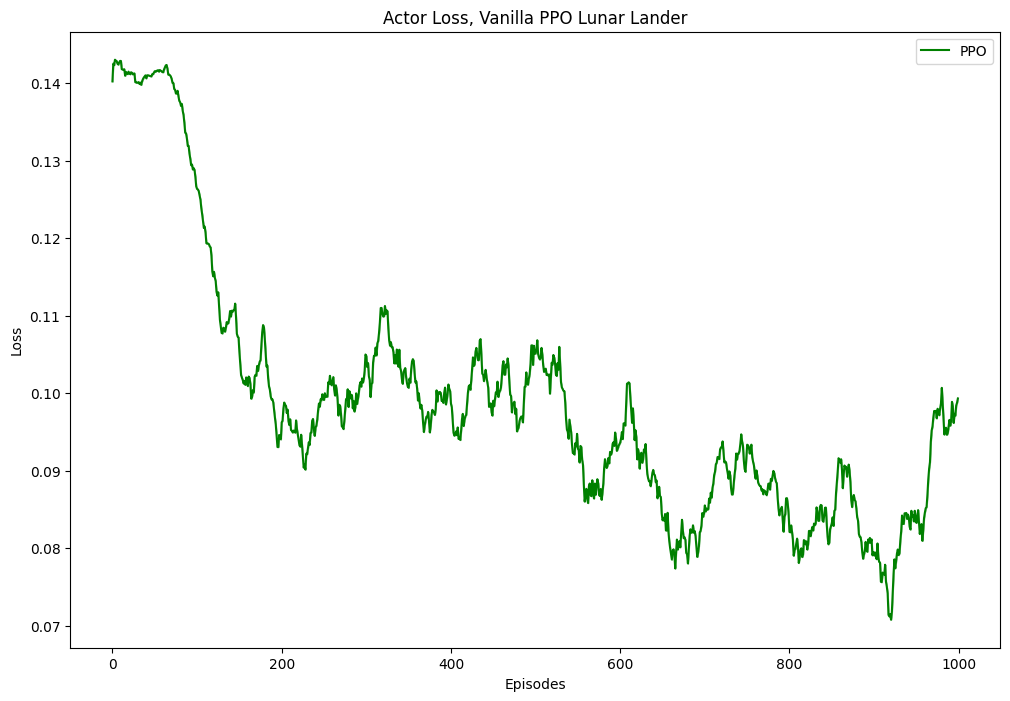

(averages - arr_err).shape=(1000,)


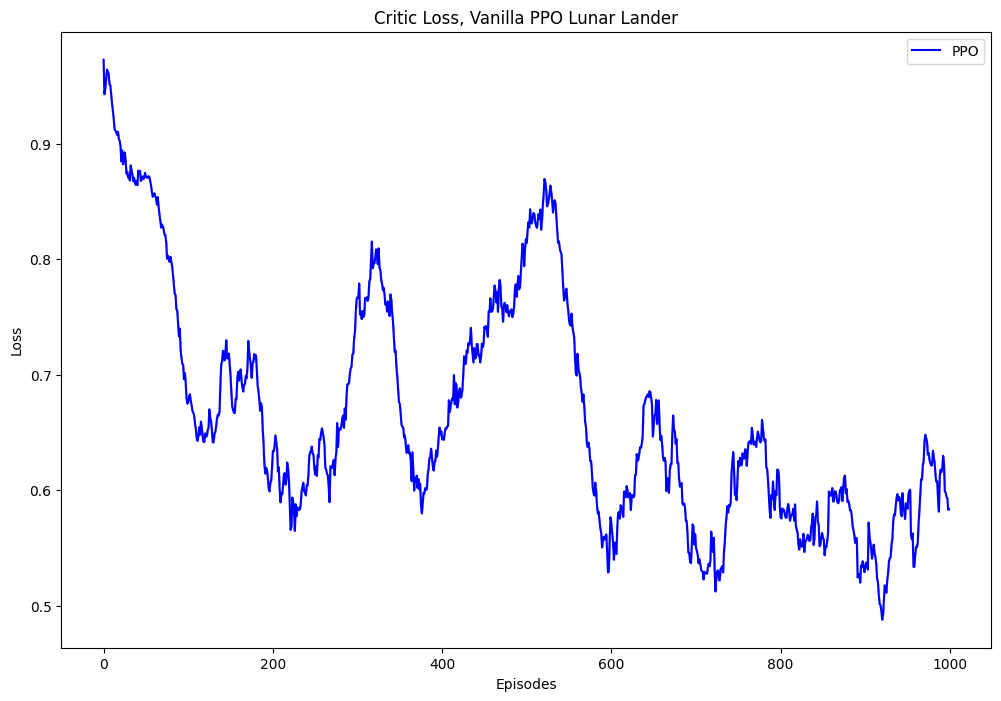

In [37]:
plot_curves([np.stack(four_rooms_stats['episode_return'])],
            ['PPO'],
            ['r'],
            xlabel='Episodes',
            ylabel='Discounted return (gamma=0.99)',
            fig_title='Training Return, Vanilla PPO Lunar Lander',
            smoothing=True)

plot_curves([np.stack(four_rooms_stats['actor_loss'])],
            ['PPO'],
            ['g'],
            xlabel='Episodes',
            ylabel='Loss',
            fig_title='Actor Loss, Vanilla PPO Lunar Lander',
            smoothing=True)

plot_curves([np.stack(four_rooms_stats['critic_loss'])],
            ['PPO'],
            ['b'],
            xlabel='Episodes',
            ylabel='Loss',
            fig_title='Critic Loss, Vanilla PPO Lunar Lander',
            smoothing=True)

## Grokfast - Low Pass Gradient Filtering with EMA

### Lunar Lander

In [ ]:
faulthandler.enable()

def train_ppo_lunar_grokfast():
    env = gym.make('LunarLander-v3')

    num_episodes = 1500

    train_params = {
        # env info
        'state_dim': 8,

        # training params
        'num_episodes': num_episodes,
        'num_trials': 5,
        'buffer_size': 2_000,
        # 'update_frequency': 1, # 10_000,
        # 'warmup_period': 10_000,

        # hyperparams
        'actor_learning_rate': 5e-4, #3e-4, # 3e-4,
        'critic_learning_rate': 1e-3, #1e-3, #1e-3,
        'gamma': 0.99,
        'entropy_coef': 0.01,
        'clip_epsilon': 0.2, # ppo clip constraint
        'epochs_per_update': 5,
        'save_filename': './checkpoints/lunar/ppo-lunar-lander',
        'model_save_frequency': num_episodes // 4,

        # Stats tracking parameters
        'avg_return_window': 25,
        'log_frequency': 50
    }

    trial_stats = {}

    for trial in range(train_params['num_trials']):
        print(f'Trial {trial}:')

        my_agent = PPOAgent(state_dim=train_params['state_dim'],
                            action_dim=4,
                            hidden_dim=128,
                            num_hidden=2)

        my_trainer = PPOAgentTrainer(my_agent, env, train_params)
        train_stats = my_trainer.train()
        update_parent_info(trial_stats, train_stats)

    return trial_stats


lunar_stats = train_ppo_lunar()
save_object('./ppo-ipy-lunar-stats.pkl', lunar_stats)